In [22]:
import pandas as pd
from io import StringIO
import os
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import HTML

from wordcloud import WordCloud

# pd.set_option('display.max_columns', None)  # or 1000
# pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', None)  # or 199


# plt.style.use('seaborn-colorblind')

plt.rcParams.update({'font.size': 22, "axes.facecolor" : "white", 'figure.autolayout': True}) # must set in top
plt.rcParams["figure.facecolor"] = 'w'
# plt.style.use("bmh")
# plt.rcParams.update({"figure.figsize" : (12, 8),
#                      "axes.facecolor" : "white",
#                      "axes.edgecolor":  "black"})


# Create an modifiable version of the responses, which is updated with new rows if a row is added to the original, the modifiable version can be used to clean the data and add additional columns 

In [23]:
def store_fig(fig, name, path = '../results/figures'):
    main_path = os.path.join(path, name)
    fig.savefig(f"{main_path}.pdf", bbox_inches="tight")
    fig.savefig(f"{main_path}.png", bbox_inches="tight")
    fig.savefig(f"{main_path}.svg", bbox_inches="tight")


modified_spreadsheets_path = '../data/modified_answers.csv'
spreadsheets_copy_path = '../data/survey_answers_copy.csv'
spreadsheets_url = 'https://docs.google.com/spreadsheets/d/13QDpZSFlIc6aD7Mtt_h-H5IZB7EA_C-soXf-9kCcLaY/export?gid=2100855304&format=csv'

def update_mod_sheet():

    response_df = pd.read_csv(spreadsheets_url, index_col = None) 
    response_df.to_csv(spreadsheets_copy_path)
    #print(response_df.index)

    mod_response_df = pd.read_csv(modified_spreadsheets_path, index_col = 0)
    mod_response_df = mod_response_df.add_suffix('_mod')
    #print(mod_response_df.index)

    response_df_merged = pd.concat([response_df, mod_response_df], axis = 1)

    #print(response_df_merged)

    updated_mod_response_df = response_df_merged.loc[:,mod_response_df.columns]
    updated_mod_response_df.columns = updated_mod_response_df.columns.str.replace("_mod","")
    updated_mod_response_df.to_csv(modified_spreadsheets_path)

    print("The following rows need to be added to the modified answers:", updated_mod_response_df[updated_mod_response_df['Timestamp'].isna()].index)
    updated_mod_response_df = updated_mod_response_df[updated_mod_response_df['Timestamp'].notna()]

    return(response_df, updated_mod_response_df)

response_df, updated_mod_response_df = update_mod_sheet()

The following rows need to be added to the modified answers: Int64Index([96], dtype='int64')


# Plot survay answer curve

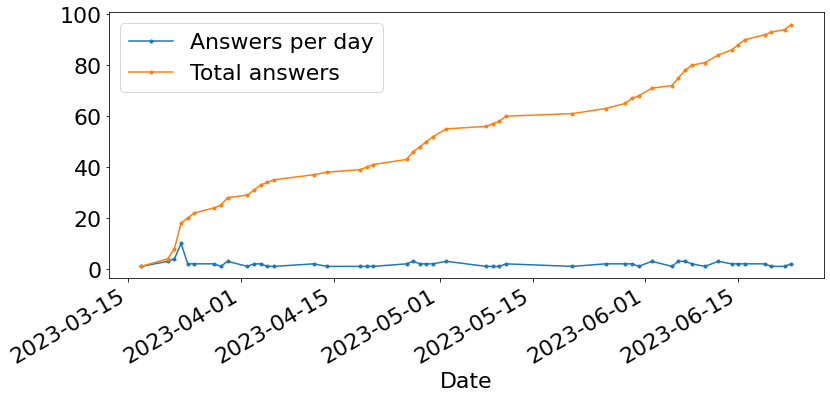

In [24]:
sub_df = updated_mod_response_df.loc[:,["Timestamp"]]

sub_df["date"] = sub_df["Timestamp"].apply(lambda x: x.split(' ')[0])


# # sub_df["date_sum"] = sub_df["date"].count()
sub_df["date"] = pd.to_datetime(sub_df["date"], dayfirst = True)

group = sub_df.groupby("date").count()
group["Total answers"] = group["Timestamp"].cumsum()
group = group.rename(columns = {"Timestamp":"Answers per day"})

fig, ax = plt.subplots(figsize = (12,6))

group.plot(ax = ax, style='.-')

# ax.set_xticks(np.arange(0, 55, 5))
ax.set_xlabel("Date")
# # ax.set_ylabel("Answer")
# ax.set_title(question)
# ax.get_legend().remove()

store_fig(fig, "survey_course")


# Plot main target

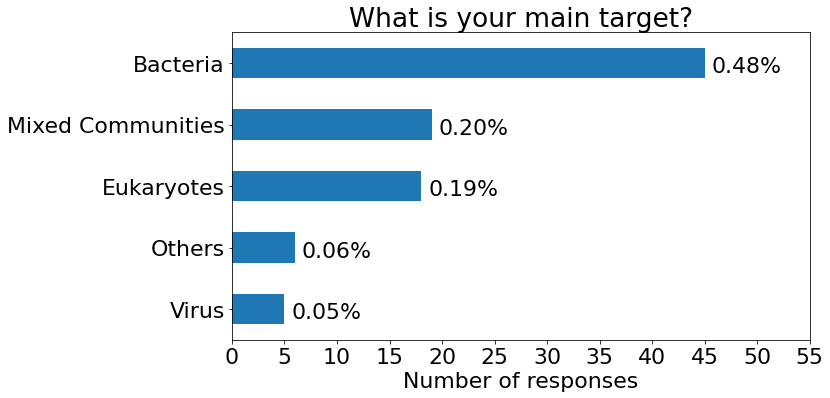

In [43]:
question = "What is your main target?"

sub_df = response_df.loc[:,question]

# get count
sub_df_count = sub_df.value_counts()
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 1)]
others = sliced_merged_df.sum()
others.name = "Others"
merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (12,6))

merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df['norm']):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val:.2f}%', (x + width + 4, y + 0.1), ha='center')

ax.set_xticks(np.arange(0, 60, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title(question)
ax.get_legend().remove()

store_fig(fig, "main_target")

# Plot technique

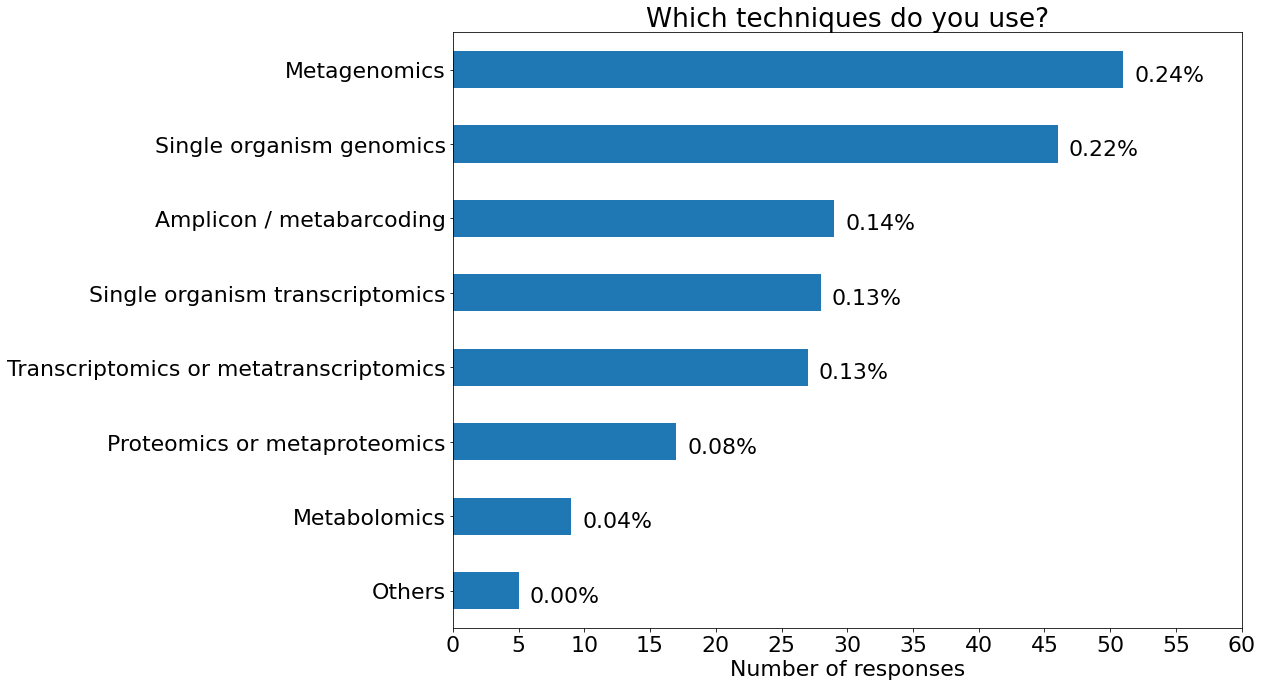

In [26]:


question = "Which techniques do you use?"
sub_df = response_df.loc[:,question]

# get count
sub_df_count = sub_df.str.get_dummies(sep=', ').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 1)]
others = sliced_merged_df.sum()
others.name = "Others"
merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (18,10))
merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df['norm']):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val:.2f}%', (x + width + 3.5, y + 0.1), ha='center')

ax.set_xticks(np.arange(0, 65, 5))
ax.set_xlabel("Number of responses")
#ax.set_ylabel("Answer")
ax.set_title(question)
ax.get_legend().remove()

store_fig(fig, "technique")

# Plot analysis

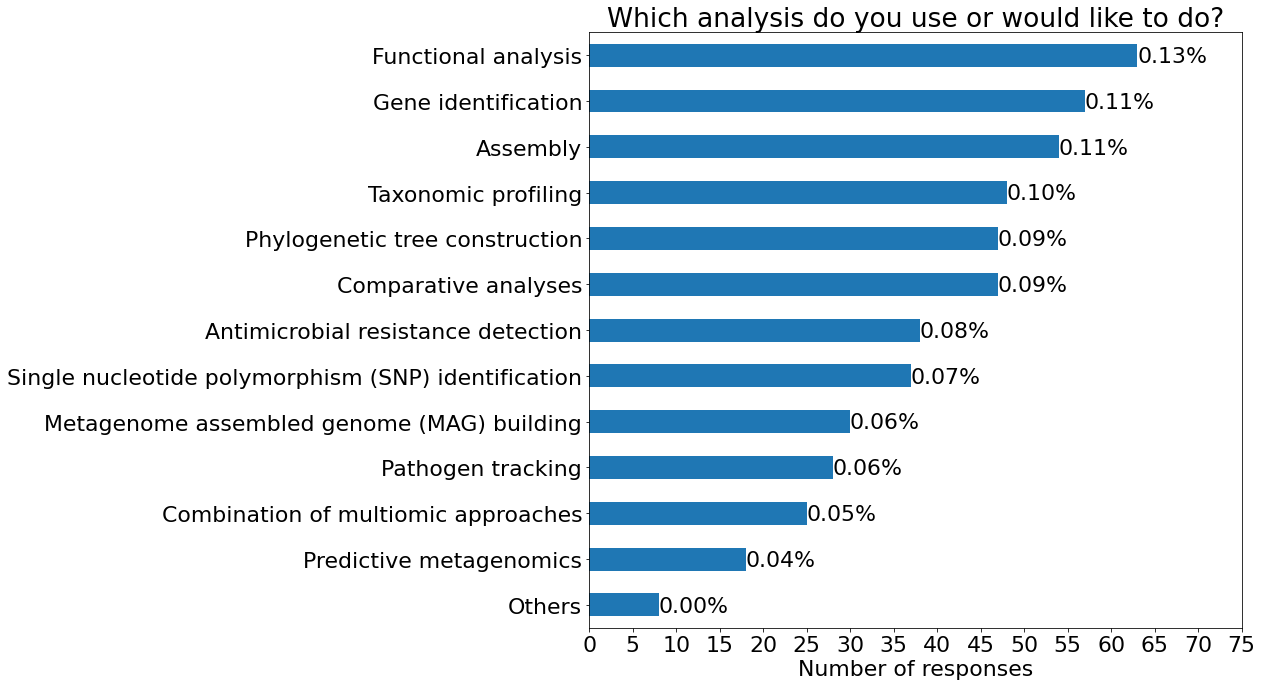

In [27]:
# analysis
replace_text = {
    "Taxonomic Profiling":"Taxonomic profiling",
    "MAGs building":"Metagenome assembled genome (MAG) building",
    "SNP identification": "Single nucleotide polymorphism (SNP) identification",
    "MAGs building": "Metagenome assembled genome (MAG) building",
    "Predictive Metagenomics": "Predictive metagenomics",
    "Functional Analysis":"Functional analysis",
}

def replace(val):
    for k, v in replace_text.items():
        val = val.replace(k, v)
    return(val)

question = "Which analysis do you use or would like to do?"
sub_df = response_df.loc[:,question]

# modify wrong text
sub_df = sub_df.dropna()
sub_df = sub_df.apply(replace)

# get count
sub_df_count = sub_df.str.get_dummies(sep=', ').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 1)]
others = sliced_merged_df.sum()
others.name = "Others"
merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")
fig, ax = plt.subplots(figsize = (18,10))
merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df['norm']):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val:.02f}%', (x + width + 4, y + 0.1), ha='center')

ax.set_xticks(np.arange(0, 80, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title(question)
ax.get_legend().remove()

store_fig(fig, "analysis")


# Plot tools

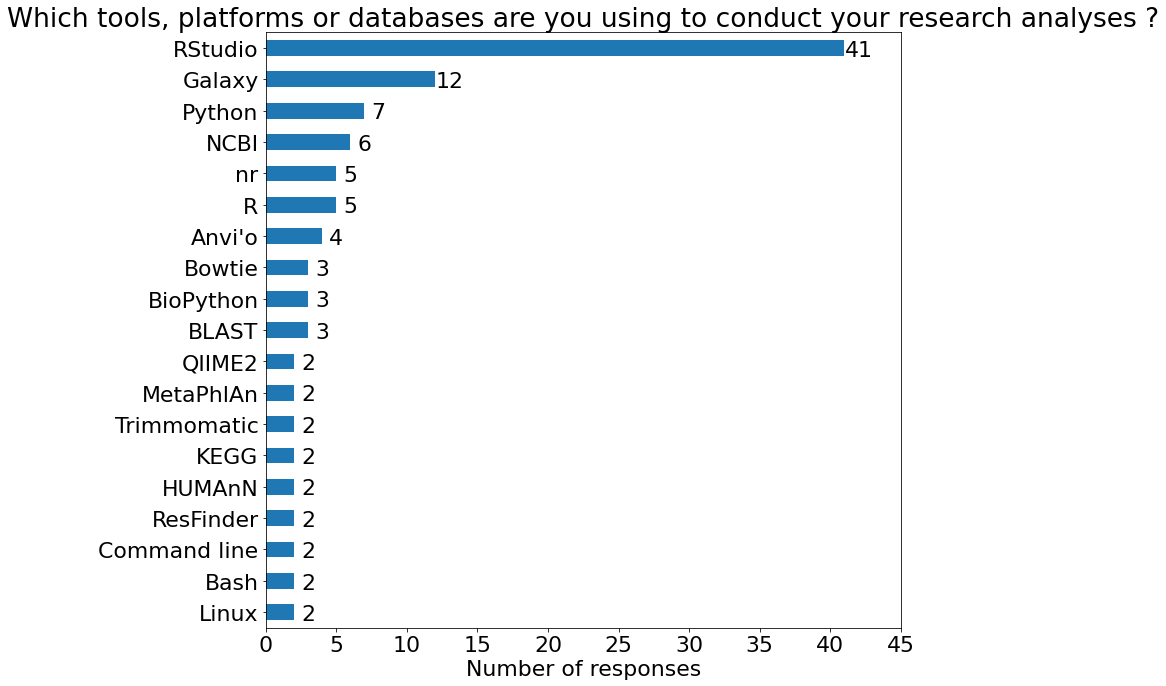

In [28]:
# tools
question = "Which tools, platforms or databases are you using to conduct your research analyses (e.g. Anvi’o, RStudio, nr, etc.)?"
sub_df = updated_mod_response_df.loc[:,question]

# get count
sub_df_count = sub_df.str.get_dummies(sep=', ').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 1)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")
fig, ax = plt.subplots(figsize = (12,10))
merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 1, y), ha='center')

ax.set_xticks(np.arange(0, 50, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("Which tools, platforms or databases are you using to conduct your research analyses ?")
ax.get_legend().remove()

store_fig(fig, "tools")


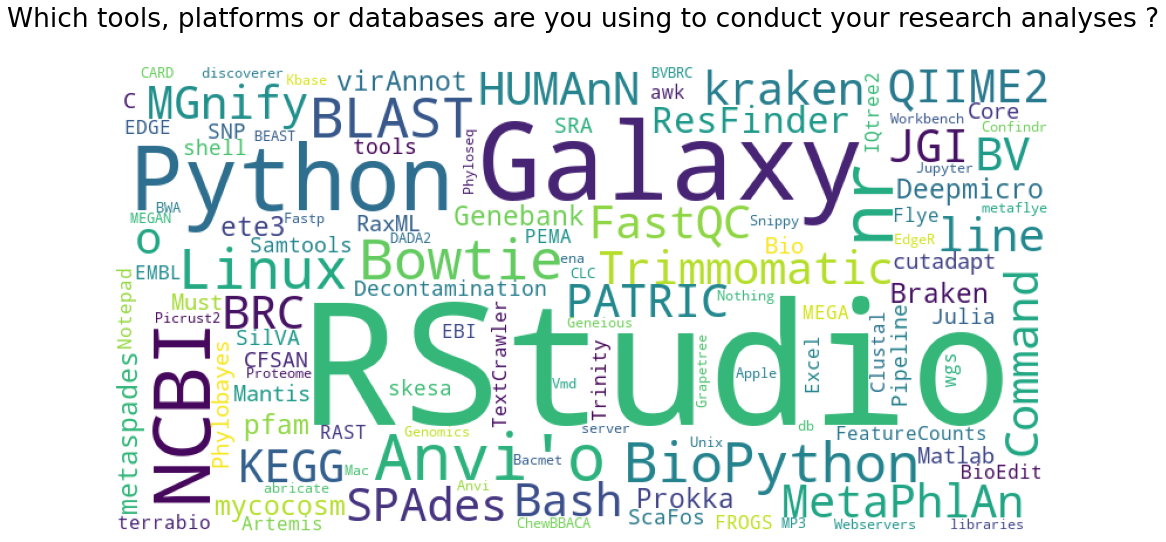

In [29]:
text_df = sub_df.dropna()
vals = []
for val in text_df:
    for v in val.split(','):
        vals.append(v.strip(' '))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(vals))

fig, ax = plt.subplots(figsize = (16,8))


ax.imshow(wordcloud)
ax.set_title("Which tools, platforms or databases are you using to conduct your research analyses ?",pad=40)
plt.axis("off")

fig.tight_layout()
# fig.savefig('figures/tools_DBs_used_for_research_wordcloud.png')
plt.show()

store_fig(fig, "tools_wordcloud")

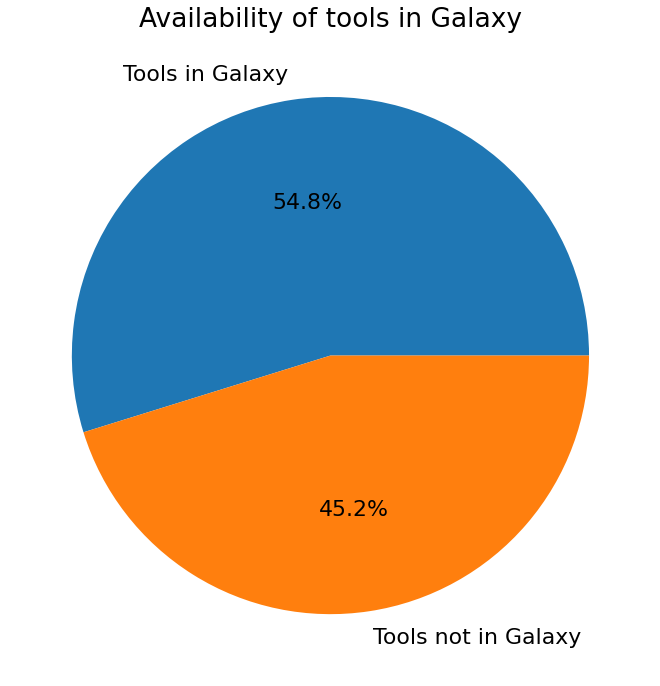

In [30]:
# How many of the used tools are in galaxy ?

tools_in_galaxy = updated_mod_response_df.loc[:,"In Galaxy"].sum()
tools_not_galaxy = updated_mod_response_df.loc[:,"Not in Galaxy"].sum()

labels = ['Tools in Galaxy', 'Tools not in Galaxy']
sizes = [tools_in_galaxy, tools_not_galaxy]

# fig, ax = plt.subplots(figsize = (15,8))
# merged_df.plot.barh(ax = ax, y = "Responses")

# for p, val in zip(ax.patches, merged_df["Responses"]):
#     width = p.get_width()
#     height = p.get_height()
#     x, y = p.get_xy() 
#     ax.annotate(f'{val}', (x + width + 0.6, y + 0.2), ha='center')

# ax.set_xticks(np.arange(0, 15, 5))
# ax.set_xlabel("Number of responses")
# # ax.set_ylabel("Answer")
# ax.set_title("Availability of tools in Galaxy")
# ax.get_legend().remove()

# store_fig(fig, "tools_in_galaxy_bar")

##############################################################

fig, ax = plt.subplots(figsize = (10,10))
# fig, ax = plt.subplots(ax = ax, facecolor='w')
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.set_title("Availability of tools in Galaxy")

store_fig(fig, "tools_in_galaxy")

# How often do you use Galaxy?

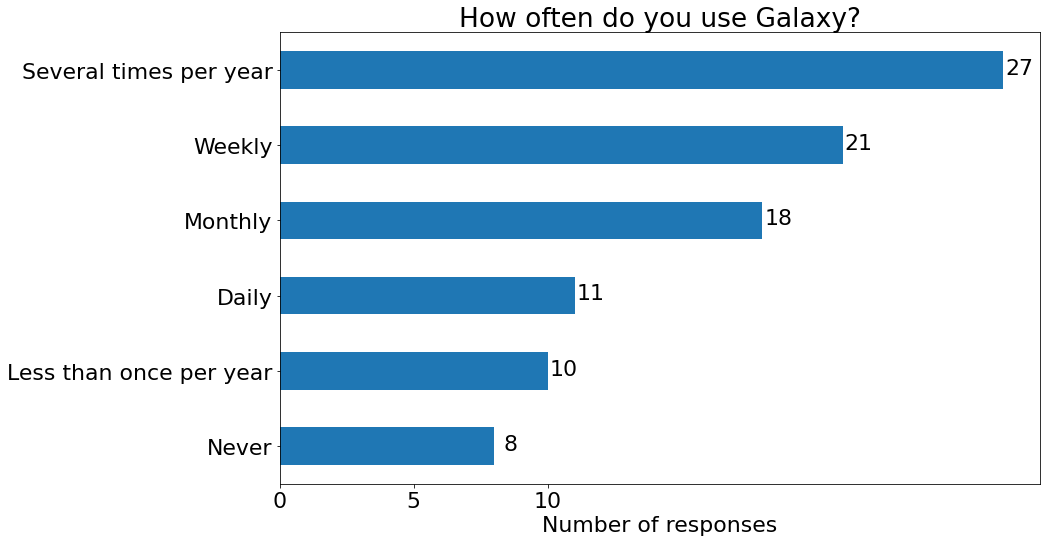

In [31]:
question = "How often do you use Galaxy?"

sub_df = response_df.loc[:,question]

# get count
sub_df_count = sub_df.value_counts()
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (15,8))
merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 0.6, y + 0.2), ha='center')

ax.set_xticks(np.arange(0, 15, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("How often do you use Galaxy?")
ax.get_legend().remove()

store_fig(fig, "how_often_use_galaxy_bar")

##################################################

# fig, ax = plt.subplots(figsize = (10,10))
# merged_df.plot.pie(ax = ax, y = "Responses", legend=False, autopct= '%.1f%%')
# ax.set_title("How often do you use Galaxy?")

# ax.set_facecolor("white")
# ax.set_ylabel('')

# store_fig(fig, "how_often_use_galaxy")

# If you never or rarely use Galaxy, what are the reasons?

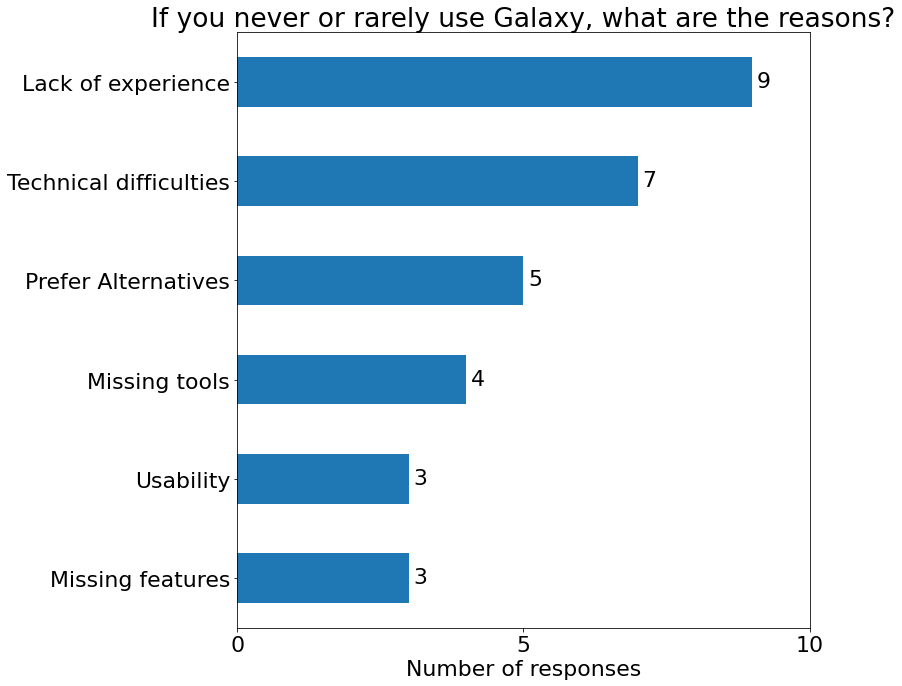

In [32]:
# tools
question = "Galaxy Obstacles"

sub_df = updated_mod_response_df.loc[:,question]

# get count
sub_df_count = sub_df.str.get_dummies(sep=', ').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 1)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (12,10))
merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 0.2, y + 0.2), ha='center')

ax.set_xticks(np.arange(0, 15, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("If you never or rarely use Galaxy, what are the reasons?")
ax.get_legend().remove()

store_fig(fig, "reasons_no_use")

# Which Galaxy server(s) do you use?

The following rows need to be added to the modified answers: Int64Index([96], dtype='int64')
[ True  True  True  True False  True False False False False False False
 False]
Local Galaxy instance       7
galaxy-sigenae Toulouse     1
galaxytrakr.org             3
usegalaxy.eu               67
usegalaxy.fr                3
usegalaxy.no                1
usegalaxy.org              31
usegalaxy.org.au           26
Name: Responses, dtype: int64


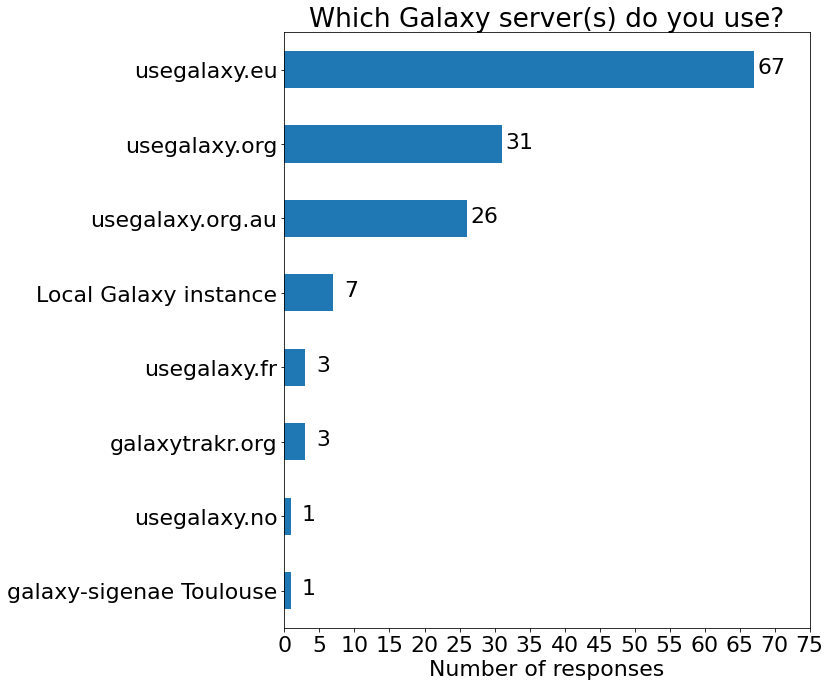

In [41]:
response_df, response_df_merged = update_mod_sheet()
question = "Which Galaxy server(s) do you use?"

sub_df = updated_mod_response_df.loc[:,question]

# get count
sub_df_count = sub_df.str.get_dummies(sep=', ').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

drop_instance = ["Galaxy Europe", "Main", "Galaxy Australia", "Galaxy Norway", "Galaxy France"]

print(sub_df_count.index.isin(drop_instance))

sub_df_count = sub_df_count[~sub_df_count.index.isin(drop_instance)]
print(sub_df_count)

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 0)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (12,10))
merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 2.5, y + 0.2), ha='center')

ax.set_xticks(np.arange(0, 80, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("Which Galaxy server(s) do you use?")
ax.legend(loc="lower right")
ax.get_legend().remove()

store_fig(fig, "server")

# Which training resources are you using?

The following rows need to be added to the modified answers: Int64Index([96], dtype='int64')


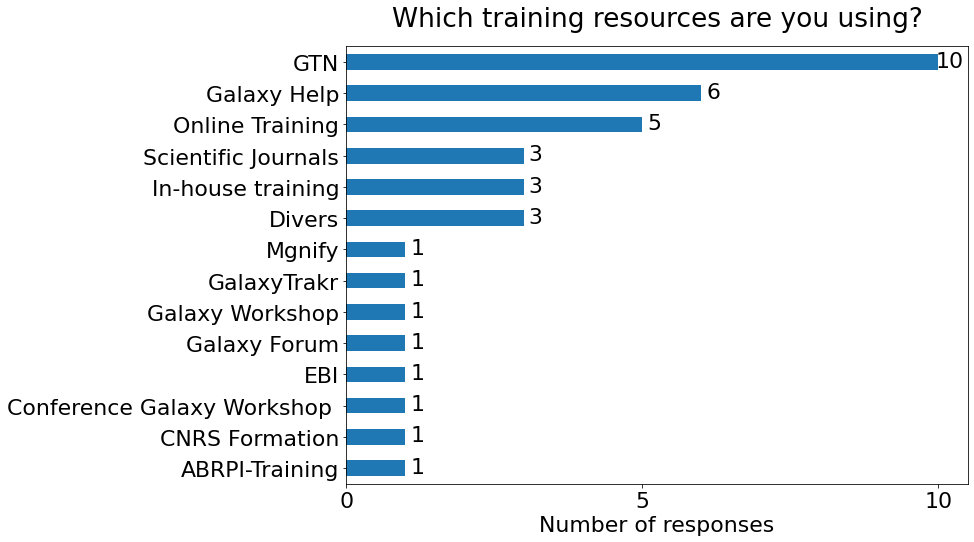

In [34]:
# tools
response_df, response_df_merged = update_mod_sheet()
question = "Training resources?"

sub_df = updated_mod_response_df.loc[:,question]

# get count
sub_df_count = sub_df.str.get_dummies(sep=', ').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 0)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (14,8))
merged_df.plot.barh(ax =  ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 0.2, y + 0.1), ha='center')

ax.set_xticks(np.arange(0, 15, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("Which training resources are you using?", pad=20)
ax.get_legend().remove()

store_fig(fig, "resources")

# Which country are you based in?

The following rows need to be added to the modified answers: Int64Index([96], dtype='int64')


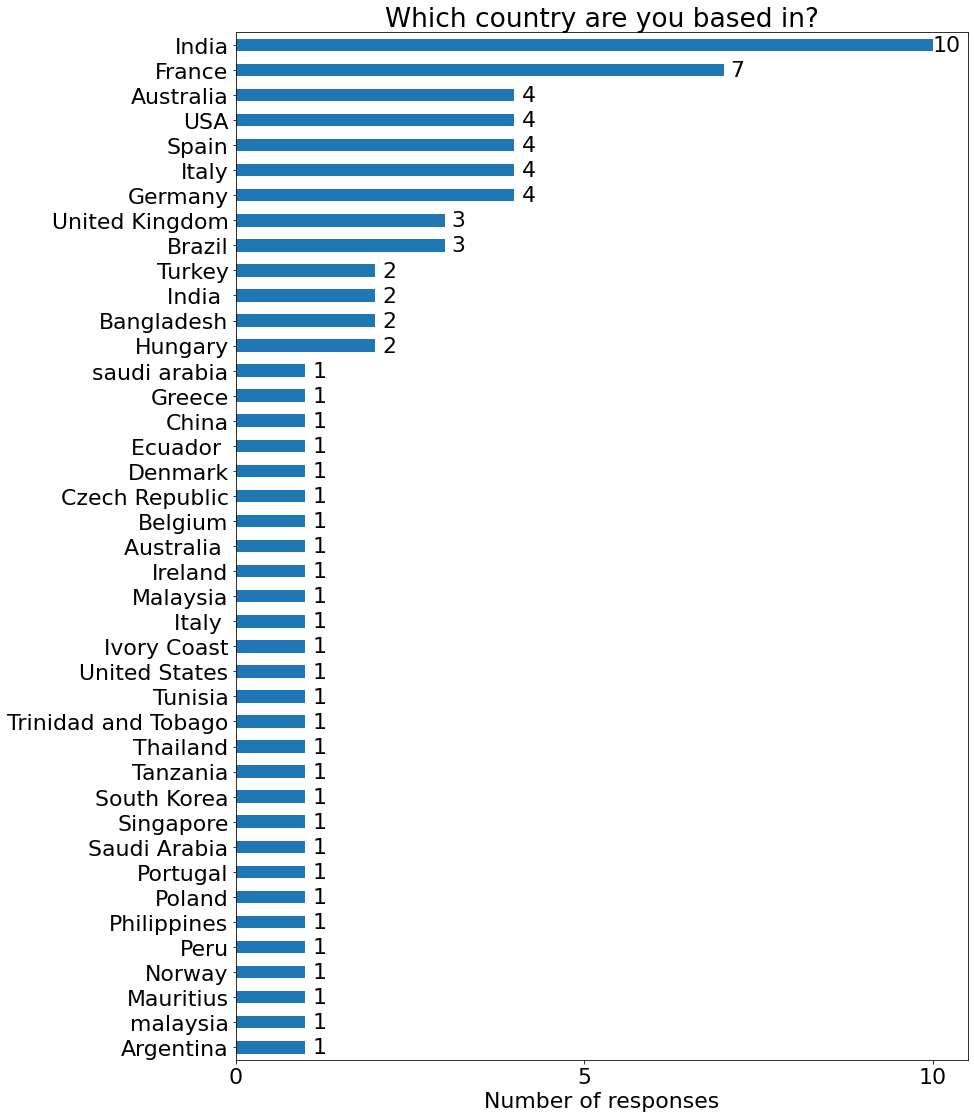

In [35]:
# tools
response_df, updated_mod_response_df = update_mod_sheet()
question = "Which country are you based in?"

sub_df = updated_mod_response_df.loc[:,question]

# get count
sub_df_count = sub_df.str.get_dummies(sep=', ').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 0)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (14,16))
ax = merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 0.2, y ), ha='center')

ax.set_xticks(np.arange(0, 15, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title(question)
ax.get_legend().remove()

store_fig(fig, "country")

The following rows need to be added to the modified answers: Int64Index([96], dtype='int64')


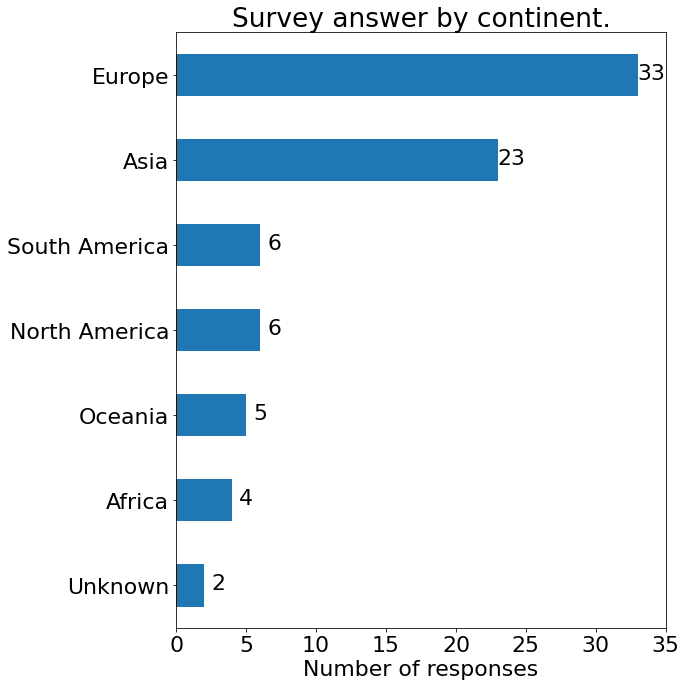

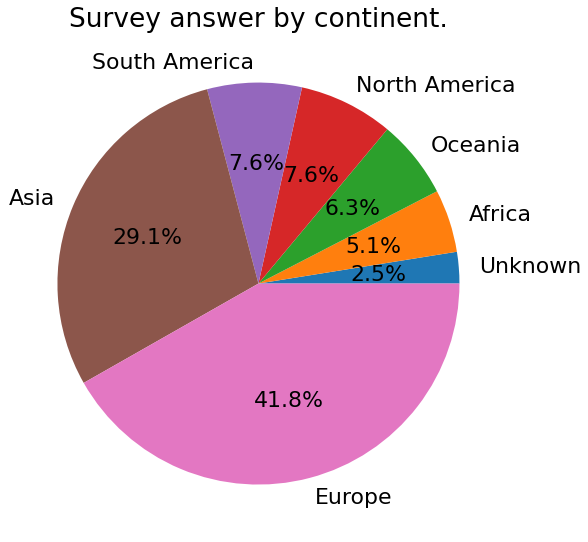

In [36]:
# continent

import pycountry_convert as pc

def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

response_df, updated_mod_response_df = update_mod_sheet()
question = "Which country are you based in?"

sub_df = updated_mod_response_df.loc[:,question]

def convert_to_continent(val):

    new_val = []
    for v in val.split(','):
        v = v.strip(' ')
        try:
            v = country_to_continent(v)
        except:
            v = 'Unknown'
        new_val.append(v)
    new_val = ','.join(new_val)
    #print(val, new_val)
    return(new_val)    
    
sub_df = sub_df.dropna()
sub_df = sub_df.apply(convert_to_continent)

# get count
sub_df_count = sub_df.str.get_dummies(sep=',').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 0)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (10,10))
ax = merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 1, y + 0.2), ha='center')

ax.set_xticks(np.arange(0, 40, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("Survey answer by continent.")
ax.get_legend().remove()
store_fig(fig, "continent_bar")

fig, ax = plt.subplots(figsize = (10,10))
ax = merged_df.plot.pie(ax = ax, y = "Responses", figsize=(12,8), legend=False, autopct= '%.1f%%')
ax.set_title("Survey answer by continent.")

ax.set_facecolor("white")
ax.set_ylabel('')

store_fig(fig, "continent_pie")

# Which tools and databases do you think are missing in Galaxy?

The following rows need to be added to the modified answers: Int64Index([96], dtype='int64')
Bracken, PlusPF,Panario, Pangolin, GWAS tools,Whole genome phylogeny,Unsure,Mgnify databases,ete3,Anvi'o, customs databases, decontamination tools,Bactopia,CNV identification,High quality figures,DAVID,Metadata integration,Pgap,Unsure,Unsure,KEGG,BLAST2GO,KOBAS,Unsure,brig, checkM,Unsure,Unsure,Core genome MLST, SNP clustering analysis, ribosomal MLST, spanning tree,BV-BRC,apFiller, GapBlast, Sealer, FinishM,  Oases, Trans-AbySS, SOAPdenovo-Trans, Qiime2,BEAST,Unsure,complex heatmaps,Unsure,axe, demultiplex, quiime,Unsure,zoonotic diseases databases,DIAMOND,Trinity statistics,Co-occurrence network analysis,GWAS, SNP detection, pseudochromosome modeling ,Pyseer, Unitigs, GWAS tools,plasmid analysis, plasmid extraction,VFDB blast,ARIBA,.,Human DB


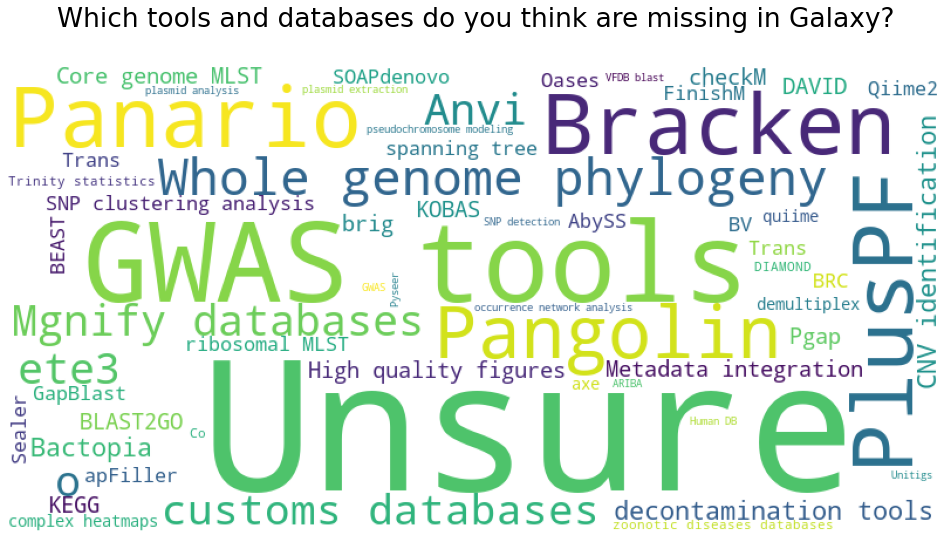

In [50]:
#TODO
response_df, updated_mod_response_df = update_mod_sheet()

question = "Missing tools ?"
sub_df = updated_mod_response_df.loc[:,question]

text_df = sub_df.dropna()
vals = []
for val in text_df:
    for v in val.split(','):
        vals.append(v.strip(' '.replace(" ","~")))

print(','.join(vals))

# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(','.join(vals))
wordcloud = WordCloud(width=800, height=400, background_color='white', regexp=r"[ \w]+", collocations=False).generate(','.join(vals))

fig, ax = plt.subplots(figsize = (16,8))

ax.imshow(wordcloud)
ax.set_title("Which tools and databases do you think are missing in Galaxy?",pad=40)
plt.axis("off")

fig.tight_layout()
store_fig(fig, "tools_missing_wordcloud")
plt.show()

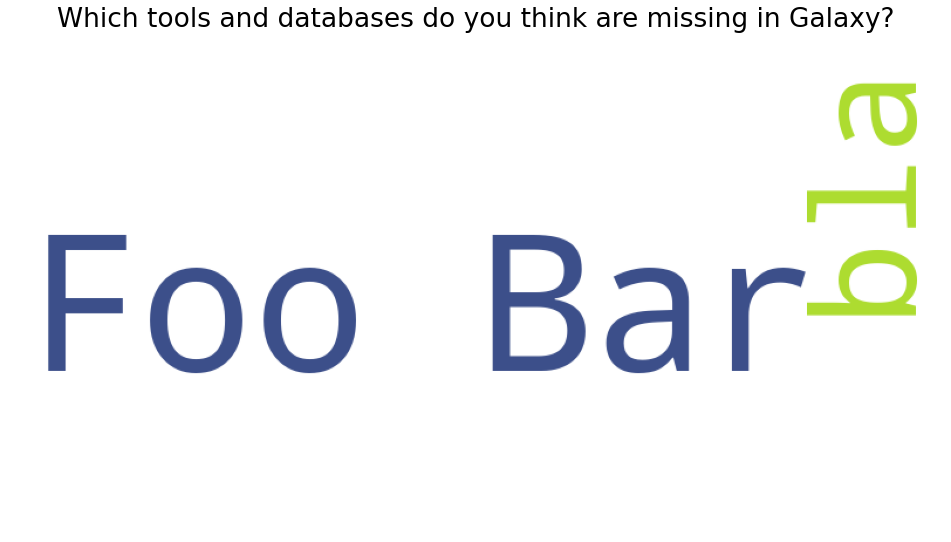

In [49]:

wordcloud = WordCloud(width=800, height=400, background_color='white', regexp=r"[ \w]+", collocations=False).generate("Foo Bar\nFoo Bar\n bla\n")

fig, ax = plt.subplots(figsize = (16,8))

ax.imshow(wordcloud)
ax.set_title("Which tools and databases do you think are missing in Galaxy?",pad=40)
plt.axis("off")

fig.tight_layout()
store_fig(fig, "tools_missing_wordcloud")
plt.show()

# What is your career stage?

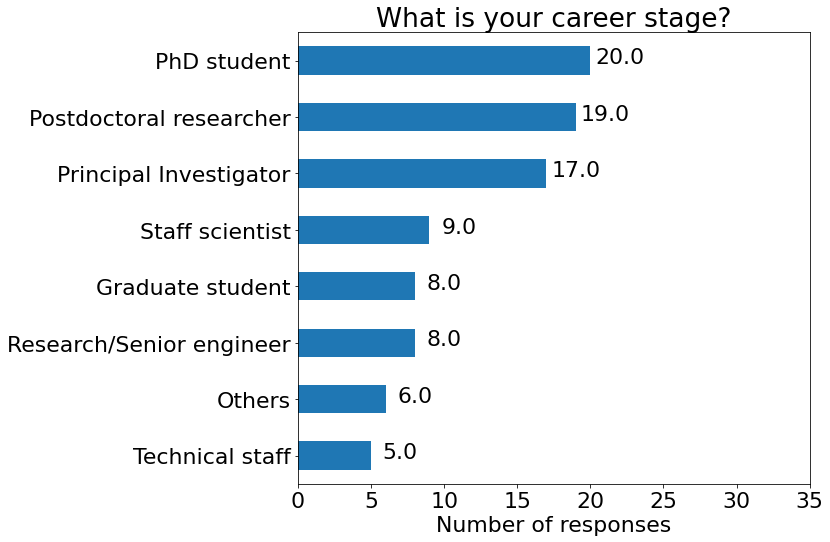

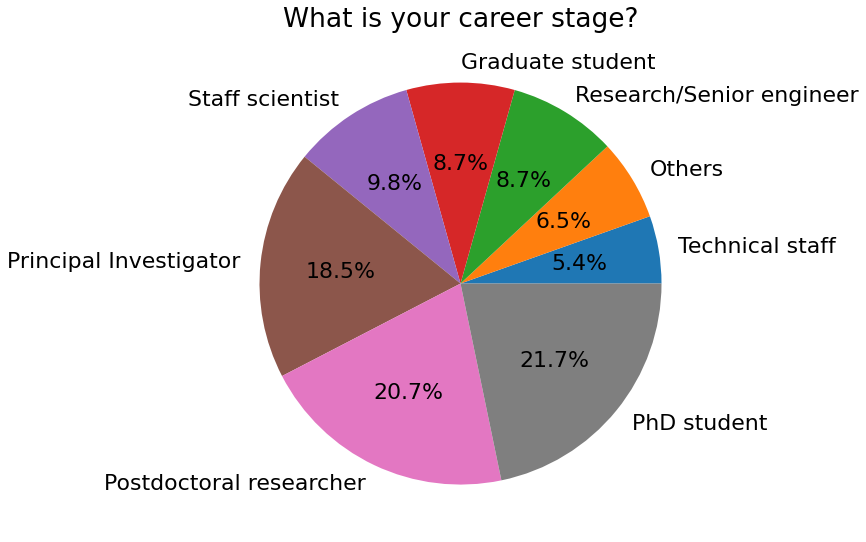

In [38]:
question = "What is your career stage?"

sub_df = response_df.loc[:,question]

# get count
sub_df_count = sub_df.value_counts()
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 1)]
others = sliced_merged_df.sum()
others.name = "Others"
merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

###################################################

fig, ax = plt.subplots(figsize = (12,8))
ax = merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 2, y + 0.2), ha='center')

ax.set_xticks(np.arange(0, 40, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title(question)
ax.get_legend().remove()
store_fig(fig, "career_bar")

##################################################

fig, ax = plt.subplots(figsize = (10,10))
merged_df.plot.pie(ax = ax, y = "Responses", figsize=(12,8), legend=False, autopct= '%.1f%%')
ax.set_title(question)

ax.set_facecolor("white")
ax.set_ylabel('')
# ax.get_legend().remove()

store_fig(fig, "career_pie")

# If the tools, platforms or databases from the previous question could be deployed in Galaxy would use prefer to use in there?

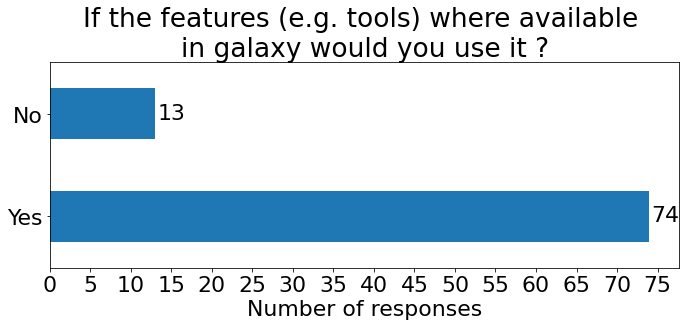

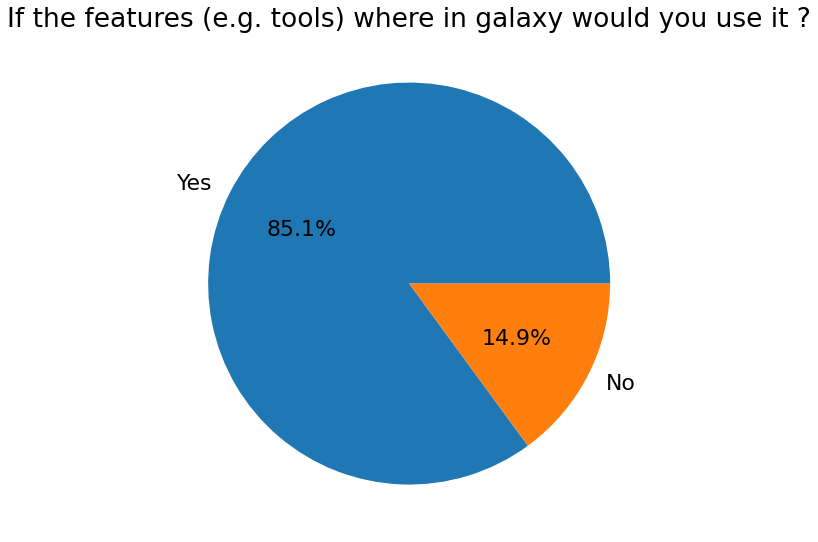

In [39]:
question = "If the tools, platforms or databases from the previous question could be deployed in Galaxy would use prefer to use in there?"

sub_df = response_df.loc[:,question]

# get count
sub_df_count = sub_df.value_counts()
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
# sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 1)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
# merged_df = merged_df.drop(sliced_merged_df.index)

fig, ax = plt.subplots(figsize = (10,5))
ax = merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 2, y + 0.2), ha='center')

ax.set_xticks(np.arange(0, 80, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("If the features (e.g. tools) where available \nin galaxy would you use it ?")
ax.get_legend().remove()
store_fig(fig, "continent_bar")

#############################################################

fig, ax = plt.subplots()
merged_df.plot.pie(ax = ax, y = "Responses", figsize=(14,8), legend=False, autopct= '%.1f%%')
ax.set_title("If the features (e.g. tools) where in galaxy would you use it ?")

ax.set_facecolor("white")
ax.set_ylabel('')

store_fig(fig, "use_it_pie")